In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ctd
import gsw

# execute a linha de comando abaixo para fazer download do conjunto de dados que serão utilizados
#!wget --directory-prefix=../dados/ https://github.com/ocefpaf/pyrantine/raw/master/notebooks/02-CTD/CTD-data/CTD-spiked-unfiltered.cnv.bz2

# lendo um arquivo .cnv, formato vindo do CTD da marca Seabird
cast = ctd.from_cnv('../dados/CTD-spiked-unfiltered.cnv.bz2')

down,up = cast.split()

down_final = down.remove_above_water()\
            .lp_filter()\
            .despike(n1=2, n2=20, block=100)\
            .press_check()\
            .interpolate()\
            .bindata(delta=1)\
            .smooth(window_len=21, window="hanning")

# extraindo metadados
metadados = cast._metadata

# extraindo pressao que é um índice
pressao = down_final.index

lon,lat = metadados['lon'], metadados['lat']


# Salinidade Prática
SP = gsw.SP_from_C(down_final['c0S/m']*10, 
                   down_final['t090C'], 
                   pressao)

# Salinidade Absoluta
SA = gsw.SA_from_SP(SP, pressao, lon, lat)

# Temperatura conservativa
CT = gsw.CT_from_t(SA, 
                   down_final['t090C'].values,
                   pressao)

# Profundidade a partir da pressão
z = -gsw.z_from_p(pressao, lat)

# Anomalia da densidade potensial
sigma0 = gsw.sigma0(SA, CT)

down_final = down_final.assign(SP=SP, 
                               SA=SA, 
                               CT=CT,
                               z=z,
                               sigma0=sigma0)


In [ ]:
# se você teve problemas para importar o pacote GSW ou CTD, 
# é pq precisa instalar:
!pip install ctd
!pip install gsw

Text(0, 0.5, 'Temperatura [oC]')

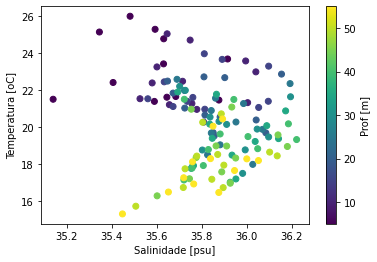

In [2]:
# com climatologia do WOA
woa_temp = pd.read_csv('../dados/temperatura_woa2018_ubatuba_60m.csv', sep=',')
woa_salt = pd.read_csv('../dados/salinidade_woa2018_ubatuba_60m.csv', sep=',')

# construir matriz de profundidade para usar como cores
depth = woa_temp.iloc[:,0].values
ndepth = np.tile(depth, (12,1)).T

# para facilitar, extrair informações de T e S 
T = woa_temp.iloc[:,1:].values
S = woa_salt.iloc[:,1:].values

# visualização
fig,ax = plt.subplots()
cs = ax.scatter(S, T, c=ndepth)
cbar = plt.colorbar(cs)
cbar.set_label('Prof [m]')
ax.set_xlabel('Salinidade [psu]')
ax.set_ylabel('Temperatura [oC]')

In [4]:
# extraindo algumas variáveis que nos ajudarão
minT,maxT = down_final['CT'].min(), down_final['CT'].max()
minS,maxS = down_final['SA'].min(), down_final['SA'].max()

dep = down_final['z'].values

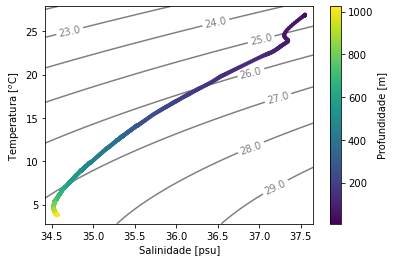

In [5]:
# usando os maximos e minimos, criamos matrizes de T e S
T = np.linspace(minT-1, maxT+1., 100)
S = np.linspace(minS-0.1, maxS+0.1, 100)

# convertemos as matrizes 1D para 2D em forma de malha (grid)
T,S = np.meshgrid(T,S)

# calculamos uma grade de densidades paramétricas
dens = gsw.sigma0(S,T)

fig,ax=plt.subplots()

# contorno de densidades
cs = ax.contour(S, T, dens, colors='grey', zorder=1)

# identificando as linhas de densidade
cl = ax.clabel(cs, fontsize=10, inline=True, fmt='%.1f')

# inserindo os pares de TS
sc = plt.scatter(down_final['SA'],
               down_final['CT'], 
               c=dep,s=10)

# customizando o gráfico
cb = plt.colorbar(sc)
cb.set_label('Profundidade [m]')
ax.set_xlabel('Salinidade [psu]')
ax.set_ylabel(r'Temperatura [$^o$C]')

plt.savefig('lec04_ex1.png', dpi=150, bbox_to_inches='tight')

# 5 - Pandas ... seu lindo!

![](https://media.istockphoto.com/photos/panda-with-tongue-out-picture-id184987985?k=6&m=184987985&s=170667a&w=0&h=xldV1zkI-b3zfWBOcS9vpgI4k5LlbbhakKFlbWgqtRk=)

**material de apoio**

- documentação Seaborn: [[link]](https://seaborn.pydata.org/)
- documentação Windrose: [[link]](https://windrose.readthedocs.io/)
- documentação Dateutils: [[link]](https://dateutil.readthedocs.io/en/stable/)


**relembrando alguns conceitos**

- estruturas de dados: Series e DataFrame
- leitura de arquivos: ```pd.read_csv``` e ```pd.read_excel```
- estatística descritiva: ```.mean()```, ```.max()```, ```.min()```, ```.sum()```, ```.std()```, ...

## Análise de série temporal

- sequência de informações
- observações, modelagem, reanálise
- eixo temporal igualmente espaçado
- explorar incosistências
- corrigir
- analisar

**Eixo temporal (DatetimeIndex)**

- pacote: datetime
- pacote: dateutil
- pacote: pandas

In [51]:
# importando os pacotes
import datetime
import dateutil
import pandas as pd

# criando algumas variáveis
agora = datetime.datetime.now()

# checando o tipo de variável
print(type(agora))
# visualizando a data. Já renderizada para o padrão internacional
print(agora)

<class 'datetime.datetime'>
2020-11-10 06:40:23.642538


- ```datetime.datetime```
- adicionar/subtrair
- ```timedelta```

In [ ]:
ontem = agora - datetime.timedelta(days=1)
print(ontem)

ontem = agora - datetime.timedelta(hours=24)
print(ontem)

ontem = agora - datetime.timedelta(seconds=86400)
print(ontem)

In [52]:
amanha = agora + datetime.timedelta(days=1)
print(amanha)

amanha = agora + datetime.timedelta(hours=24)
print(amanha)

amanha = agora + datetime.timedelta(seconds=86400)
print(amanha)

2020-11-11 06:40:23.642538
2020-11-11 06:40:23.642538
2020-11-11 06:40:23.642538


- durante análise de dados: YYYY-mm-dd HH:MM:SS
- formatar saída
- ```.strftime()```
- opções: https://strftime.org/

In [56]:
# todas as datas em decimais
print(agora.strftime('%d/%m/%Y %H:%M:%S'))

# mês abreviado
print(agora.strftime('%d/%b/%Y %H:%M:%S'))

# dia da semana
print(agora.strftime('%A'))

# número do dia no ano 
print(agora.strftime('%j'))

10/11/2020 06:40:23
10/Nov/2020 06:40:23
Tuesday
315


- ```10 Jan 2001 13:15:00```
- datetime não converte
- dateutil.parser.parse
- documentação: https://dateutil.readthedocs.io/en/stable/

In [ ]:
data_baguncada = '10 Jan 2001 13:15:00'

datetime.datetime(data_baguncada)

In [61]:
data = dateutil.parser.parse(data_baguncada)
print(type(data_baguncada))
print(type(data))
print(data)

<class 'str'>
<class 'datetime.datetime'>
2001-01-10 13:15:00


**Mas como trabalhar com datas em uma série temporal longa?**

- pandas: ferramentas internas
- depende do arquivo
- PNBOIA podemos utilizar dois métodos:
    - conversão do Epoch (Epoca): ```1970-01-01 00 (UTC)```
    - construção a partir das colunas de tempo

In [91]:
# lendo algumas colunas do arquivo PNBOIA Vitoria
df = pd.read_csv('../dados/pnboia_vitoria.csv', 
                 usecols=[0,3,4,5, 6, 7])

df.head()

,# Epoca,Year,Month,Day,Hour,Minute
0,1444755600,2015,10,13,17,21
1,1444759200,2015,10,13,18,21
2,1444762800,2015,10,13,19,21
3,1444766400,2015,10,13,20,21
4,1444770000,2015,10,13,21,21


**Primeiro método**: convertendo *Epoch*

In [90]:
# extraindo primeira linha para visualização apenas
linha1 = df.iloc[0:1]
linha1

,# Epoca,Year,Month,Day,Hour,Minute
0,1444755600,2015,10,13,17,21


In [133]:
datetime.datetime\
            .fromtimestamp(linha1['# Epoca'])\
            .strftime('%Y-%m-%d %H:%M:%S')

'2015-10-13 14:00:00'

Notem:

- diferença de horas
- conversão considera nosso fuso horário
- arquivo está em UTC

**Segundo método**: convertendo as colunas

- durante a leitura
- argumentos:
    - ```date_parser```: qual a função que vai converter de um formato para outro
    - ```parse_dates```: quais colunas irão gerar o eixo temporal

In [122]:
# funcao: será utilizada no date_parser
def dateparse(x):
    return pd.datetime.strptime(x, '%Y %m %d %H %M')

# podemos usar funções lambda
# dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H %M')

df = pd.read_csv('../dados/pnboia_vitoria.csv',
                 parse_dates={'datetime': ['Year', 'Month', 'Day', 'Hour', 'Minute']},
                 date_parser=dateparse,
                 decimal=',',
                 )

df.head()

,datetime,# Epoca,Lat,Lon,Battery,bHead,Wspd,Wspdflag,Wspdflagid,Wdir,...,Wmax,Wmaxflag,Wmaxflagid,Dpd,Dpdflag,Dpdflagid,Mwd,Mwdflag,Mwdflagid,Spred
0,2015-10-13 17:21:00,1444755600,-19.935850,-39.704233,-9999.0,98.66,11.409288,0,0,52,...,2.54,0,0,8.0,0,0,63,0,0,31.3
1,2015-10-13 18:21:00,1444759200,-19.935883,-39.704183,-9999.0,98.36,11.083308,0,0,52,...,2.31,0,0,8.7,0,0,67,0,0,31.2
2,2015-10-13 19:21:00,1444762800,-19.936000,-39.704100,-9999.0,97.30,11.843927,0,0,51,...,3.09,0,0,8.7,0,0,59,0,0,31.1
3,2015-10-13 20:21:00,1444766400,-19.936133,-39.703967,-9999.0,99.90,13.582485,0,0,55,...,3.06,0,0,6.1,0,0,57,0,0,32.9
4,2015-10-13 21:21:00,1444770000,-19.936117,-39.703933,-9999.0,96.21,12.387227,0,0,49,...,2.73,0,0,5.6,0,0,53,0,0,32.7


Notem:

- nova coluna
- antigas colunas de tempo não existem mais

In [123]:
# agora podemos converter nossa coluna datetime em index
df.set_index('datetime', inplace=True)

df.head()

,# Epoca,Lat,Lon,Battery,bHead,Wspd,Wspdflag,Wspdflagid,Wdir,Wdirflag,...,Wmax,Wmaxflag,Wmaxflagid,Dpd,Dpdflag,Dpdflagid,Mwd,Mwdflag,Mwdflagid,Spred
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-13 17:21:00,1444755600,-19.935850,-39.704233,-9999.0,98.66,11.409288,0,0,52,0,...,2.54,0,0,8.0,0,0,63,0,0,31.3
2015-10-13 18:21:00,1444759200,-19.935883,-39.704183,-9999.0,98.36,11.083308,0,0,52,0,...,2.31,0,0,8.7,0,0,67,0,0,31.2
2015-10-13 19:21:00,1444762800,-19.936000,-39.704100,-9999.0,97.30,11.843927,0,0,51,0,...,3.09,0,0,8.7,0,0,59,0,0,31.1
2015-10-13 20:21:00,1444766400,-19.936133,-39.703967,-9999.0,99.90,13.582485,0,0,55,0,...,3.06,0,0,6.1,0,0,57,0,0,32.9
2015-10-13 21:21:00,1444770000,-19.936117,-39.703933,-9999.0,96.21,12.387227,0,0,49,0,...,2.73,0,0,5.6,0,0,53,0,0,32.7


**Criando eixo temporal do zero**

- data de início
- data final 
- frequência temporal 
- ```pd.date_range()```

In [ ]:
# frequência horária, diária, mensal
eixo_temporal = pd.date_range(start='2020-10-20', 
                              end='2020-11-20',
                              freq='H')
eixo_temporal

**Visualização de série temporal**

<AxesSubplot:xlabel='datetime'>

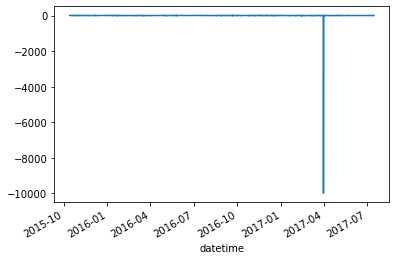

In [125]:
df['Wspd'].plot()

Presença clara de outlier. Vamos identificar que valor é este e substituí-lo por ```NaN```.

In [135]:
df['Wspd'].min()
# df = df.replace(-9999, np.nan)
# df['Wspd'].plot()

**Filtrando dados pelo tempo**

<AxesSubplot:xlabel='datetime'>

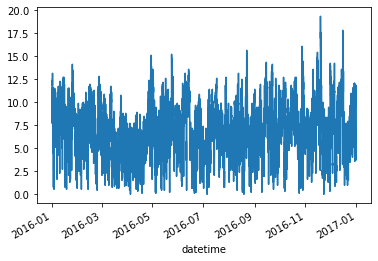

In [128]:
# plotando nintensidade do vento para o ano de 2016
df['2016']['Wspd'].plot()

# # intensidade do vento para Janeiro de 2017
# df['2017-01']['Wspd'].plot()

**Agrupameneto (groupby)**

- chaves (keys): grupos
- eixo (axis, 0 para linhas, 1 para colunas)
- método estatístico a ser utilizado no agrupamento (sum, mean, max, min, etc)

![](https://camo.githubusercontent.com/eaa4d59f0d7edf93a6d04918dce79d902c305534/68747470733a2f2f7374617469632e7061636b742d63646e2e636f6d2f70726f64756374732f393738313738333938353132382f67726170686963732f353132384f535f30395f30312e6a7067)

<AxesSubplot:xlabel='datetime'>

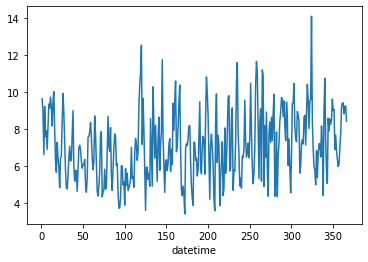

In [136]:
# calculando a climatologia diária da intensidade do vento
df['Wspd'].groupby(df.index.dayofyear).mean().plot()

<AxesSubplot:xlabel='datetime'>

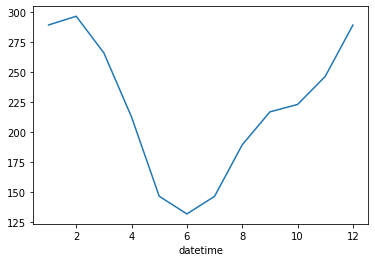

In [138]:
# calculando a climatologia mensal da radiação solar
df['Arad'].groupby(df.index.month).mean().plot()

# segundo plot: radiação solar diária
# df['Arad'].groupby(df.index.hour).mean().plot(kind='bar')

**Reamostragem (resample)**

- rule: horária, diária, quinzenal, mensal, por estação
- método estatístico



In [139]:
# reamostrar para média diária
df.resample('D').mean()['Wspd'].head()

datetime
2015-10-13    11.937064
2015-10-14     9.969544
2015-10-15    10.499261
2015-10-16    10.911263
2015-10-17     8.719956
Freq: D, Name: Wspd, dtype: float64

<AxesSubplot:xlabel='datetime'>

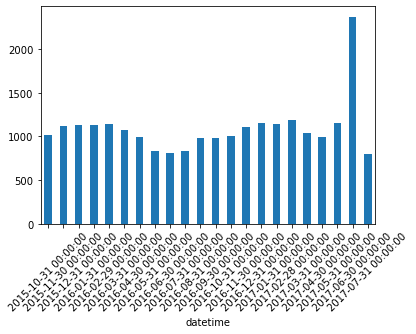

In [144]:
# reamostrar para máximo mensal
df.resample('M').max()['Arad'].plot(kind='bar', rot=45)

,Wtmp,Atmp
Wtmp,1.00000,0.81464
Atmp,0.81464,1.00000


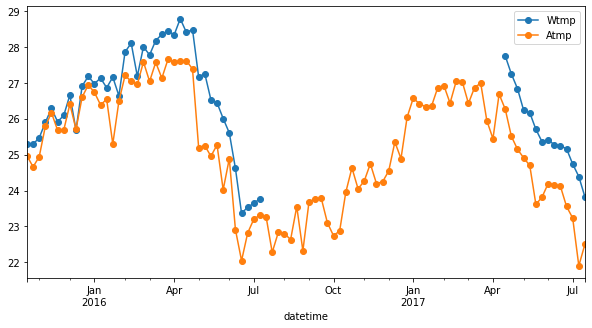

In [162]:
#existe correlação entre temperatura da superfície do mar e do ar?
df[['Wtmp', 'Atmp']].resample("W").mean()\
                    .plot(style="-o",
                          figsize=(10, 5))

df[['Wtmp', 'Atmp']].corr()

Para as próximas visualizações, vamos utilizar um outro pacote chamado ```seaborn```.

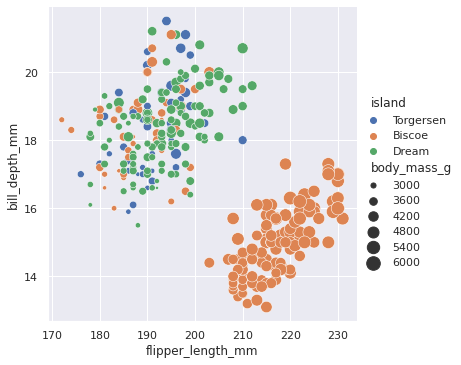

In [14]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# preparando o dataframe
species = sns.load_dataset('penguins')

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

g = sns.relplot(
    data=species,
    x="flipper_length_mm", y="bill_depth_mm",
    hue="island", size="body_mass_g", sizes=(10, 200),
)

In [6]:
# regressão linear com distribuição marginal
data = df.resample('D').mean().reset_index()

g = sns.jointplot(x='Atmp', y='Wtmp', data=data, kind='reg', truncate=False)

NameError: name 'df' is not defined

In [71]:
# carregando dataset de salmão capturados no Pacífico Norte: https://www.bco-dmo.org/dataset/3106
fish = pd.read_csv('https://erddap.bco-dmo.org/erddap/tabledap/bcodmo_dataset_3106.csv',
                  dtype={'haul_id': int, 'weight_wet': float, 'length_wet': float, 'depth_w': float,
                         'sex': str, 'maturity': str, 'species_common_name': str},
                  skiprows=[1,2],
                  usecols=[0, 3, 9, 10, 12, 14, 15, 16])

# reduzindo o tamanho
data = fish[fish['year'] == 2001]

data.head()

,year,haul_id,depth_w,species_common_name,length_wet,weight_wet,sex,maturity
0,2001,2001001,64.0,Chum,698.0,4108.0,M,A
1,2001,2001001,64.0,Chum,NaN,NaN,NaN,J
2,2001,2001001,64.0,Chum,NaN,NaN,NaN,J
3,2001,2001001,64.0,Chum,NaN,NaN,NaN,J
4,2001,2001001,64.0,Chum,NaN,NaN,NaN,J


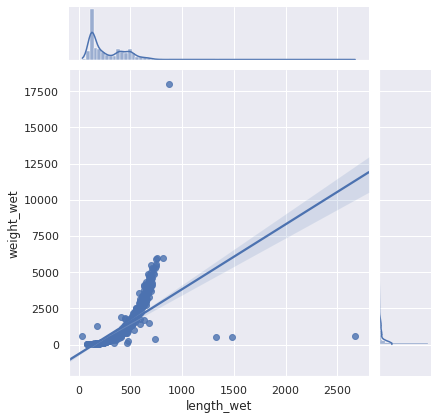

In [70]:
# peso x comprimento com regressão linear ajustada e a distribuição 
g = sns.jointplot(x='length_wet', y='weight_wet', data=data, kind='reg', truncate=False)

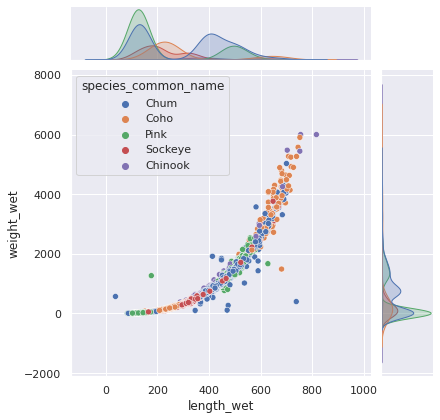

In [92]:
# limpeza ingênua
data[(data['length_wet'] > 1000)] = np.nan
data[(data['weight_wet'] > 10000)] = np.nan

# peso x comprimento com regressão linear ajustada e a distribuição 
g = sns.jointplot(x="length_wet", y="weight_wet", hue="species_common_name", 
                  data=data)

<AxesSubplot:xlabel='species_common_name'>

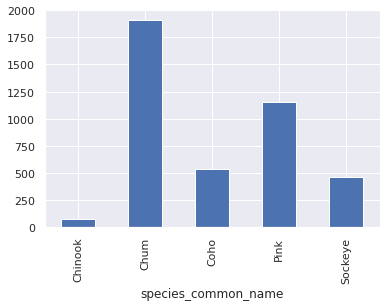

In [93]:
# quantidade de indivíduos por espécie
data.groupby('species_common_name').count().plot(kind='bar', y='year', legend=False)

Cuidado com NaN na contagem!

In [80]:
# Tomar cuidado com os nan (.count() com e sem nan values é muito diferente)

# data.groupby('maturity').count()
data.dropna(axis=0, how='any').groupby('maturity').count()

,year,haul_id,depth_w,species_common_name,length_wet,weight_wet,sex
maturity,,,,,,,
A,455,455,455,455,455,455,455
I,722,722,722,722,722,722,722
J,21,21,21,21,21,21,21


### Introdução aos exercícios

- leitura de arquivo excel
- limpeza e ajustes do conjunto de dados
- responder perguntas através do conhecimento de filtragem, agrupamento, etc

- conjunto de dados do IBAMA: localidades afetadas pela mancha de óleo em 2019

Responda:

- Utilizando groupby, count e plot, monte um gráfico de barras e responda: qual o Estado mais afetado segundo o conjunto de dados?

- Da mesma forma, mas sem necessidade de figura, agrupe por Município e apresente quais foram os 10 mais afeatdos

- Filtre o conjunto de dados para identificar as primeiras e últimas localidades afetadas.

- Por fim, qual a localidade afetada por mais tempo?

In [94]:
url = "http://www.ibama.gov.br/phocadownload/emergenciasambientais/2019/manchasdeoleo/2019-12-02_LOCALIDADES_AFETADAS.xlsx"
df = pd.read_excel(
    url,
    parse_dates=["Data_Avist", "Data_Revis"],
)

# Calculando o tempo de permanência da mancha em cada localidade
df["dias"] = (df["Data_Revis"] - df["Data_Avist"]).dt.days

# tratando as colunas de tempo
df['Data_Avist'] = df['Data_Avist'].dt.strftime('%Y-%m-%d').str.replace('NaT', 'na')
df["Data_Revis"] = df["Data_Revis"].dt.strftime("%Y-%m-%d").str.replace("NaT", "na")
df["dias"] = df["dias"].astype('Int64').astype(str).str.replace("nan", "na")

df.dropna(inplace=True)
df.head()

,geocodigo,localidade,loc_id,municipio,estado,sigla_uf,Data_Avist,Data_Revis,Status,Latitude,Longitude,dias
0,3201605,Praia de Guriri,3201605_43,Conceição da Barra,Espírito Santo,ES,2019-11-23,2019-11-23,Oleada - Vestigios / Esparsos,"18° 40' 43.70"" S","39° 44' 33.69"" W",0
1,3201605,Praia de Guriri,3201605_46,Conceição da Barra,Espírito Santo,ES,2019-11-18,2019-11-19,Oleada - Vestigios / Esparsos,"18° 42' 14.87"" S","39° 44' 45.92"" W",1
2,3201605,Praia de Guriri,3201605_45,Conceição da Barra,Espírito Santo,ES,2019-11-21,2019-11-27,Oleada - Vestigios / Esparsos,"18° 41' 54.57"" S","39° 44' 40.31"" W",6
3,2207702,Praia do Pontal,2207702_4,Parnaíba,Piauí,PI,2019-11-08,2019-11-17,Oleada - Vestigios / Esparsos,"2° 45' 46.58"" S","41° 46' 54.03"" W",9
4,3202405,Praia do Morro,3202405_39,Guarapari,Espírito Santo,ES,2019-11-28,2019-11-28,Oleada - Vestigios / Esparsos,"20° 39' 18.19"" S","40° 28' 42.74"" W",0


### Outro exercício

Para quem quiser avançar um pouco na visualização de dados, vamos ver como criar wind rose (diagramas direcionais) com dados de direção de corrente, vento e ondas.

Para isso, utilizaremos o conjunto de dados do PNBOIA Vitória. 

1. Vá ao site da Marinha Brasileira [[link]](https://www.marinha.mil.br/chm/dados-do-goos-brasil/pnboia)
2. Baie o arquivo de metadados para o PNBOIA
3. Identifique as colunas correspondentes a:
    - direção e intensidade do vento
    - direção e intensidade da corrente próximo a superfície
    - direção e altura significativa de onda
    
4. Com as informações acima, monte três dataframes com essas informações, classificadas para três variáveis (vento, corrente e onda), todas indexadas pelo tempo

5. Utilizando o pacote ```windrose```, monte os diagramas direcionais para as variáveis.

Nota: atente-se para as convenções matemática, oceanográfica e meteorológica na hora de plotar. O pacote ```windrose``` possui um argumento para lidar com a definição das convenções meteorológicas. Procura na documentação do pacote por esse argumento: [[link]](https://windrose.readthedocs.io/)

In [ ]:
# para instalar o windrose no Google-Colab, use:
!pip install windrose

# importar
import windrose